In [1]:
from Data_Preprocessing import exp_var, hate_crime, indexed_df

import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns

import warnings
warnings.filterwarnings('once')

C:\Users\aspen\Documents\LAUNCH-CODE\Final_Project\Data_Preprocessing.py:159: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  ts_df['INCIDENT_MONTH'] = pd.to_datetime(ts_df['INCIDENT_DATE']).dt.to_period('M')
C:\Users\aspen\anaconda3\lib\site-packages\pandas\core\frame.py:4906: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  return super().drop(
C:\Users\aspen\Documents\LAUNCH-CODE\Final_Project\Data_Preprocessing.py:164: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

In [2]:
exp_var

['hate_crime',
 'hate_crime_combined',
 'hc_by_year',
 'region_grouped',
 'race_grouped',
 'indexed_df']

In [3]:
## Formulate timeseries into supervised learning problem

https://machinelearningmastery.com/how-to-develop-an-autoregression-forecast-model-for-household-electricity-consumption/

https://towardsdatascience.com/time-series-forecast-in-python-using-sarimax-and-prophet-c970e6056b5b

In [4]:
## drop null values created by differencing
indexed_df.dropna(axis=1, inplace=True)

#ensure frequency is set for timeseries models
indexed_df = indexed_df.asfreq('M')
indexed_df_mod = indexed_df.copy()

In [5]:
replace_dict={1966:(indexed_df.loc['2000-09-30']['TOTAL_INCIDENTS'] + indexed_df.loc['2002-09-30']['TOTAL_INCIDENTS'])/2, 
              1048:(indexed_df.loc['2000-10-31']['TOTAL_INCIDENTS'] + indexed_df.loc['2002-10-31']['TOTAL_INCIDENTS'])/2, 
              1470:(indexed_df.loc['2019-06-30']['TOTAL_INCIDENTS'] + indexed_df.loc['2020-05-31']['TOTAL_INCIDENTS'])/2, 
              1155:(indexed_df.loc['2019-07-31']['TOTAL_INCIDENTS'] + indexed_df.loc['2020-05-31']['TOTAL_INCIDENTS'])/2, 
              1085:(indexed_df.loc['2019-08-31']['TOTAL_INCIDENTS'] + indexed_df.loc['2020-05-31']['TOTAL_INCIDENTS'])/2, 
              1004:(indexed_df.loc['2019-10-31']['TOTAL_INCIDENTS'] + indexed_df.loc['2020-09-30']['TOTAL_INCIDENTS'])/2 
             }

print(replace_dict)

indexed_df_mod.replace(to_replace=replace_dict, inplace=True)

{1966: 762.0, 1048: 772.0, 1470: 736.0, 1155: 742.5, 1085: 745.0, 1004: 845.0}


In [6]:
indexed_df[:]

,TOTAL_INCIDENTS
INCIDENT_MONTH,
1991-01-31,302
1991-02-28,287
1991-03-31,287
1991-04-30,309
1991-05-31,371
...,...
2020-08-31,1085
2020-09-30,952
2020-10-31,1004


In [7]:
#training set 1991-2015
#test set 2015-2020
#train, test = indexed_df[:300], indexed_df[300:]

In [8]:
def series_to_supervised(data, n_in=1, n_out=1, dropnan=False):
    """
    Frame a time series as a supervised learning dataset.
    Arguments:
        data: Sequence of observations as a list or NumPy array.
        n_in: Number of lag observations as input (X).
        n_out: Number of observations as output (y).
        dropnan: Boolean whether or not to drop rows with NaN values.
    Returns:
        Pandas DataFrame of series framed for supervised learning.
    """
    n_vars = 1 if type(data) is list else data.shape[1]
    df = pd.DataFrame(data)
    cols, names = list(), list()
    # input sequence (t-n, ... t-1)
    for i in range(n_in, 0, -1):
        cols.append(df.shift(i))
        names += [('var%d(t-%d)' % (j+1, i)) for j in range(n_vars)]
    # forecast sequence (t, t+1, ... t+n)
    for i in range(0, n_out):
        cols.append(df.shift(-i))
        if i == 0:
            names += [('var%d(t)' % (j+1)) for j in range(n_vars)]
        else:
            names += [('var%d(t+%d)' % (j+1, i)) for j in range(n_vars)]
    # put it all together
    agg = pd.concat(cols, axis=1)
    agg.columns = names
    # drop rows with NaN values
    if dropnan:
        agg.dropna(inplace=True)
    return agg

In [9]:
x = [n for n in indexed_df['TOTAL_INCIDENTS']]
data=series_to_supervised(x, n_in=3, n_out=3)
data

,var1(t-3),var1(t-2),var1(t-1),var1(t),var1(t+1),var1(t+2)
0,NaN,NaN,NaN,302,287.0,287.0
1,NaN,NaN,302.0,287,287.0,309.0
2,NaN,302.0,287.0,287,309.0,371.0
3,302.0,287.0,287.0,309,371.0,363.0
4,287.0,287.0,309.0,371,363.0,461.0
...,...,...,...,...,...,...
355,773.0,1470.0,1155.0,1085,952.0,1004.0
356,1470.0,1155.0,1085.0,952,1004.0,780.0
357,1155.0,1085.0,952.0,1004,780.0,654.0
358,1085.0,952.0,1004.0,780,654.0,NaN


### Timeseries with SARIMAX

In [10]:
#research forecasting with SARIMAX for existing timeseries
from statsmodels.tsa.statespace.sarimax import SARIMAX

In [11]:
#p = lags in the autoregresive model
p = 5
#d = differencing / integration order
d = 1
#q = moving average lags
q = 4

my_order=(p,d,q)

#Seasonal order
P = 5
D = 1
Q = 4
m = 12

my_seasonal_order = (P,D,Q,m)

In [12]:
model = SARIMAX(indexed_df['TOTAL_INCIDENTS'], order=my_order, seasonal_order=(my_seasonal_order))
results = model.fit()
results.summary()

C:\Users\aspen\anaconda3\lib\site-packages\statsmodels\tsa\statespace\sarimax.py:966: UserWarning: Non-stationary starting autoregressive parameters found. Using zeros as starting parameters.
  warn('Non-stationary starting autoregressive parameters'
C:\Users\aspen\anaconda3\lib\site-packages\statsmodels\tsa\statespace\sarimax.py:978: UserWarning: Non-invertible starting MA parameters found. Using zeros as starting parameters.
  warn('Non-invertible starting MA parameters found.'
C:\Users\aspen\anaconda3\lib\site-packages\statsmodels\base\model.py:566: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "


<class 'statsmodels.iolib.summary.Summary'>
"""
                                     SARIMAX Results                                      
==========================================================================================
Dep. Variable:                    TOTAL_INCIDENTS   No. Observations:                  360
Model:             SARIMAX(5, 1, 4)x(5, 1, 4, 12)   Log Likelihood               -2099.842
Date:                            Mon, 07 Mar 2022   AIC                           4237.683
Time:                                    00:05:01   BIC                           4310.821
Sample:                                01-31-1991   HQIC                          4266.804
                                     - 12-31-2020                                         
Covariance Type:                              opg                                         
==============================================================================
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
ar.L1         -0.2205      0.101     -2.176      0.030      -0.419      -0.022
ar.L2          0.9625      0.090     10.728      0.000       0.787       1.138
ar.L3          0.7334      0.072     10.192      0.000       0.592       0.874
ar.L4         -0.4534      0.073     -6.250      0.000      -0.596      -0.311
ar.L5         -0.0359      0.064     -0.558      0.577      -0.162       0.090
ma.L1         -0.3049      1.345     -0.227      0.821      -2.940       2.331
ma.L2         -1.2832      1.014     -1.266      0.206      -3.270       0.704
ma.L3         -0.3647      1.870     -0.195      0.845      -4.029       3.300
ma.L4          0.9634      1.545      0.623      0.533      -2.065       3.992
ar.S.L12       0.1391      3.242      0.043      0.966      -6.214       6.493
ar.S.L24       0.7635      1.134      0.673      0.501      -1.459       2.986
ar.S.L36      -0.2712      4.078     -0.066      0.947      -8.265       7.722
ar.S.L48       0.0982      0.415      0.237      0.813      -0.716       0.912
ar.S.L60       0.0327      0.318      0.103      0.918      -0.590       0.656
ma.S.L12      -0.9409      3.154     -0.298      0.765      -7.123       5.241
ma.S.L24      -0.7841      2.315     -0.339      0.735      -5.321       3.753
ma.S.L36       0.9300      5.007      0.186      0.853      -8.884      10.744
ma.S.L48      -0.1891      3.721     -0.051      0.959      -7.483       7.105
sigma2      9734.9907   1.48e+04      0.660      0.509   -1.92e+04    3.86e+04
===================================================================================
Ljung-Box (L1) (Q):                   0.00   Jarque-Bera (JB):             81628.42
Prob(Q):                              0.97   Prob(JB):                         0.00
Heteroskedasticity (H):               0.45   Skew:                             6.44
Prob(H) (two-sided):                  0.00   Kurtosis:                        77.03
===================================================================================

Warnings:
[1] Covariance matrix calculated using the outer product of gradients (complex-step).
"""

C:\Users\aspen\anaconda3\lib\site-packages\statsmodels\tsa\base\tsa_model.py:132: FutureWarning: The 'freq' argument in Timestamp is deprecated and will be removed in a future version.
  date_key = Timestamp(key, freq=base_index.freq)


<AxesSubplot:xlabel='INCIDENT_MONTH'>

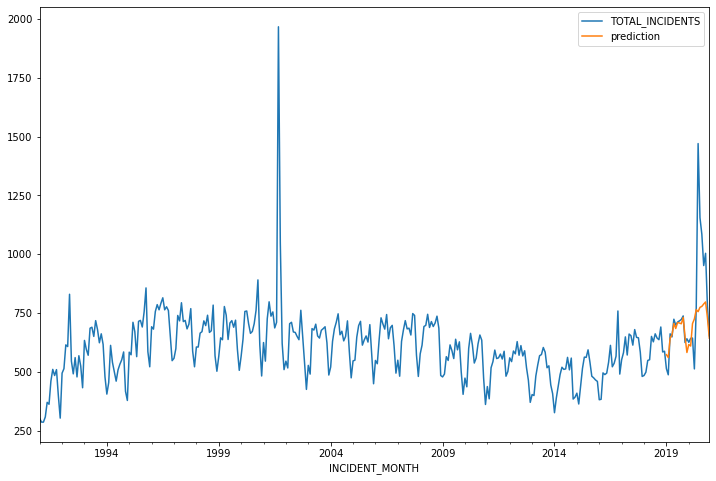

In [13]:
indexed_df['prediction']=results.predict(start='2019-01',end='2020-12',dynamic=True)
indexed_df[['TOTAL_INCIDENTS','prediction']].plot(figsize=(12,8))

### Forecasting with Complete Dataset

In [14]:
y = indexed_df['TOTAL_INCIDENTS']

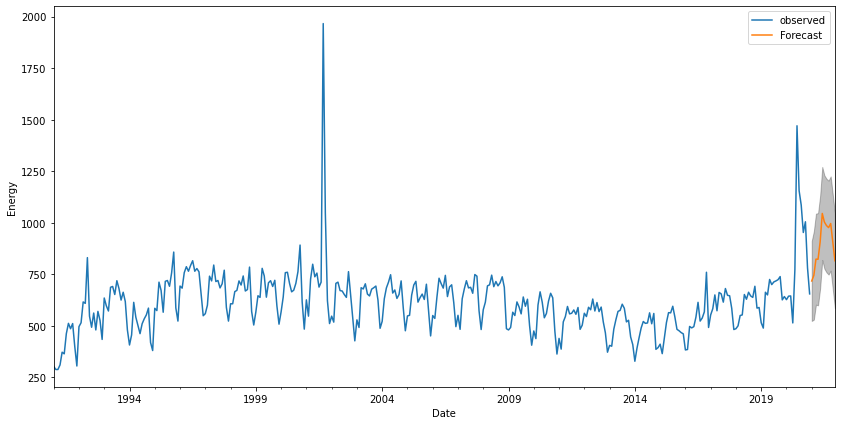

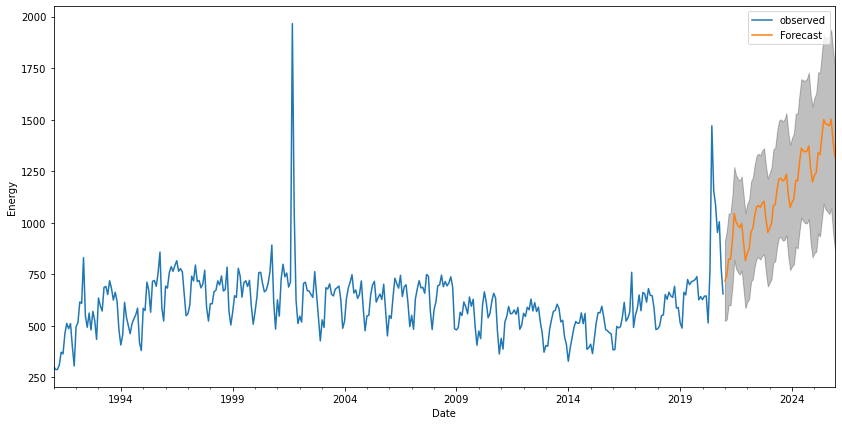

In [15]:
#%% Forecast 1y
years = 1
pred_uc = results.get_forecast(steps=12*years)
pred_ci = pred_uc.conf_int()
ax = y.plot(label='observed', figsize=(14, 7))
pred_uc.predicted_mean.plot(ax=ax, label='Forecast')
ax.fill_between(pred_ci.index,
                pred_ci.iloc[:, 0],
                pred_ci.iloc[:, 1], color='k', alpha=.25)
ax.set_xlabel('Date')
ax.set_ylabel('Energy')
plt.legend()
plt.show()
#plt.savefig(current_dir + os.sep + 'SARIMAX_FORECAST_1y.png')
#plt.close()

#%% Forecast 5y
years = 5
pred_uc = results.get_forecast(steps=12*years)
pred_ci = pred_uc.conf_int()
ax = y.plot(label='observed', figsize=(14, 7))
pred_uc.predicted_mean.plot(ax=ax, label='Forecast')
ax.fill_between(pred_ci.index,
                pred_ci.iloc[:, 0],
                pred_ci.iloc[:, 1], color='k', alpha=.25)
ax.set_xlabel('Date')
ax.set_ylabel('Energy')
plt.legend()
plt.show()
#plt.savefig(current_dir + os.sep + 'SARIMAX_FORECAST_5y.png')
#plt.close()

### Forecasting with Outliers Removed

In [16]:
model = SARIMAX(indexed_df_mod['TOTAL_INCIDENTS'], order=my_order, seasonal_order=(my_seasonal_order))
results = model.fit()
results.summary()

C:\Users\aspen\anaconda3\lib\site-packages\statsmodels\tsa\statespace\sarimax.py:966: UserWarning: Non-stationary starting autoregressive parameters found. Using zeros as starting parameters.
  warn('Non-stationary starting autoregressive parameters'
C:\Users\aspen\anaconda3\lib\site-packages\statsmodels\tsa\statespace\sarimax.py:978: UserWarning: Non-invertible starting MA parameters found. Using zeros as starting parameters.
  warn('Non-invertible starting MA parameters found.'
C:\Users\aspen\anaconda3\lib\site-packages\statsmodels\base\model.py:566: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "


<class 'statsmodels.iolib.summary.Summary'>
"""
                                     SARIMAX Results                                      
==========================================================================================
Dep. Variable:                    TOTAL_INCIDENTS   No. Observations:                  360
Model:             SARIMAX(5, 1, 4)x(5, 1, 4, 12)   Log Likelihood               -1894.531
Date:                            Mon, 07 Mar 2022   AIC                           3827.061
Time:                                    00:07:24   BIC                           3900.198
Sample:                                01-31-1991   HQIC                          3856.182
                                     - 12-31-2020                                         
Covariance Type:                              opg                                         
==============================================================================
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
ar.L1          0.0559      0.565      0.099      0.921      -1.051       1.162
ar.L2          0.2438      0.492      0.495      0.620      -0.721       1.209
ar.L3          0.8667      0.292      2.964      0.003       0.294       1.440
ar.L4         -0.2476      0.241     -1.028      0.304      -0.720       0.224
ar.L5         -0.0245      0.111     -0.222      0.825      -0.242       0.193
ma.L1         -0.5136      0.564     -0.910      0.363      -1.620       0.593
ma.L2         -0.4048      0.225     -1.798      0.072      -0.846       0.036
ma.L3         -0.7478      0.111     -6.715      0.000      -0.966      -0.530
ma.L4          0.6963      0.438      1.589      0.112      -0.162       1.555
ar.S.L12      -0.3775      0.336     -1.123      0.261      -1.036       0.281
ar.S.L24       0.0197      0.362      0.054      0.957      -0.690       0.729
ar.S.L36       0.7591      0.430      1.765      0.078      -0.084       1.602
ar.S.L48      -0.0971      0.172     -0.566      0.572      -0.434       0.239
ar.S.L60      -0.0240      0.129     -0.186      0.853      -0.278       0.230
ma.S.L12      -0.4660      4.302     -0.108      0.914      -8.897       7.965
ma.S.L24      -0.3330      0.644     -0.517      0.605      -1.595       0.929
ma.S.L36      -0.7390      8.445     -0.088      0.930     -17.290      15.812
ma.S.L48       0.7768      5.413      0.144      0.886      -9.832      11.386
sigma2      3361.0057   2.22e+04      0.152      0.880   -4.01e+04    4.68e+04
===================================================================================
Ljung-Box (L1) (Q):                   0.09   Jarque-Bera (JB):               278.26
Prob(Q):                              0.77   Prob(JB):                         0.00
Heteroskedasticity (H):               0.82   Skew:                             0.19
Prob(H) (two-sided):                  0.29   Kurtosis:                         7.37
===================================================================================

Warnings:
[1] Covariance matrix calculated using the outer product of gradients (complex-step).
"""

C:\Users\aspen\anaconda3\lib\site-packages\statsmodels\tsa\base\tsa_model.py:132: FutureWarning: The 'freq' argument in Timestamp is deprecated and will be removed in a future version.
  date_key = Timestamp(key, freq=base_index.freq)


<AxesSubplot:xlabel='INCIDENT_MONTH'>

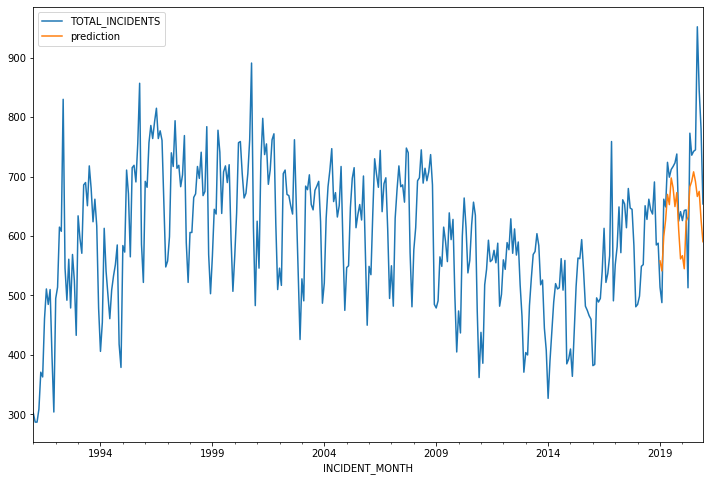

In [17]:
indexed_df_mod['prediction']=results.predict(start='2019-01',end='2020-12',dynamic=True)
indexed_df_mod[['TOTAL_INCIDENTS','prediction']].plot(figsize=(12,8))

In [18]:
y = indexed_df_mod['TOTAL_INCIDENTS']

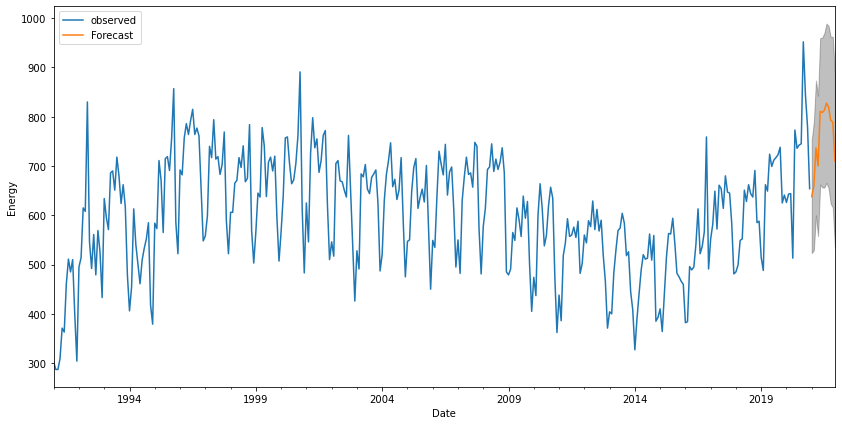

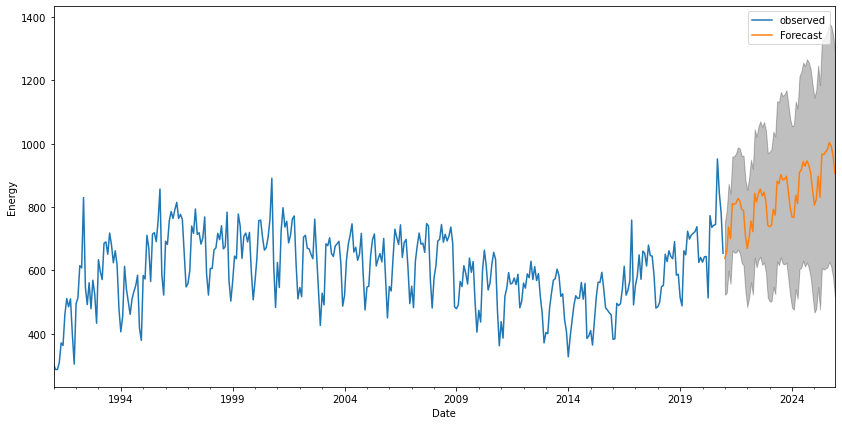

In [19]:
#%% Forecast 1y
years = 1
pred_uc = results.get_forecast(steps=12*years)
pred_ci = pred_uc.conf_int()
ax = y.plot(label='observed', figsize=(14, 7))
pred_uc.predicted_mean.plot(ax=ax, label='Forecast')
ax.fill_between(pred_ci.index,
                pred_ci.iloc[:, 0],
                pred_ci.iloc[:, 1], color='k', alpha=.25)
ax.set_xlabel('Date')
ax.set_ylabel('Energy')
plt.legend()
plt.show()
#plt.savefig(current_dir + os.sep + 'SARIMAX_FORECAST_1y.png')
#plt.close()

#%% Forecast 5y
years = 5
pred_uc = results.get_forecast(steps=12*years)
pred_ci = pred_uc.conf_int()
ax = y.plot(label='observed', figsize=(14, 7))
pred_uc.predicted_mean.plot(ax=ax, label='Forecast')
ax.fill_between(pred_ci.index,
                pred_ci.iloc[:, 0],
                pred_ci.iloc[:, 1], color='k', alpha=.25)
ax.set_xlabel('Date')
ax.set_ylabel('Energy')
plt.legend()
plt.show()
#plt.savefig(current_dir + os.sep + 'SARIMAX_FORECAST_5y.png')
#plt.close()

## NEXT for Supervised Learning

Aggregate based on bias type, show the number of incidents per year per bias type along with the president's political affiliation.  Use top 3-5 biases.

Then train test split and try to predict the political affiliation for a given year.

In [3]:
hate_crime

,DATA_YEAR,STATE_ABBR,REGION_NAME,POPULATION_GROUP_CODE,INCIDENT_DATE,TOTAL_OFFENDER_COUNT,OFFENDER_RACE,VICTIM_COUNT,OFFENSE_NAME,LOCATION_NAME,BIAS_DESC,VICTIM_TYPES,TOTAL_INCIDENTS
0,1991,AR,South,5,1991-08-31,1,White,1,Intimidation,Highway/Road/Alley/Street/Sidewalk,Anti-Black or African American,Individual,1
1,1991,AR,South,6,1991-09-19,1,Black or African American,1,Simple Assault,Highway/Road/Alley/Street/Sidewalk,Anti-White,Individual,1
2,1991,AR,South,3,1991-07-04,1,Black or African American,1,Aggravated Assault,Residence/Home,Anti-Black or African American,Individual,1
3,1991,AR,South,3,1991-12-24,1,Black or African American,2,Aggravated Assault;Destruction/Damage/Vandalis...,Highway/Road/Alley/Street/Sidewalk,Anti-White,Individual,1
4,1991,AR,South,3,1991-12-23,1,Black or African American,1,Aggravated Assault,Service/Gas Station,Anti-White,Individual,1
...,...,...,...,...,...,...,...,...,...,...,...,...,...
219572,2020,WY,West,5,2020-11-29,6,White,2,Intimidation,Park/Playground,Anti-Lesbian (Female),Individual,1
219573,2020,WY,West,5,2020-07-14,0,Unknown,1,Destruction/Damage/Vandalism of Property,Park/Playground,Anti-White,Government,1
219574,2020,WY,West,5,2020-10-16,1,Black or African American,1,Aggravated Assault,Residence/Home,Anti-White,Individual,1
219575,2020,WY,West,5,2020-01-30,1,White,1,Simple Assault,Residence/Home,Anti-Female,Individual,1


In [4]:
hate_crime['BIAS_DESC'].value_counts()

Anti-Black or African American                    75266
Anti-Jewish                                       28169
Anti-White                                        25205
Anti-Gay (Male)                                   21945
Anti-Hispanic or Latino                           14073
Anti-Lesbian (Female)                             11276
Anti-Other Race/Ethnicity/Ancestry                10772
Anti-Asian                                         6445
Anti-Multiple Races, Group                         5256
Anti-Islamic (Muslim)                              3973
Anti-Other Religion                                3536
Anti-Native American                               2385
Anti-Catholic                                      1628
Anti-Arab                                          1269
Anti-Protestant                                    1264
Anti-Multiple Religions                            1197
Anti-Mental Disability                             1193
Anti-Transgender                                

In [5]:
#group by bias type -- ADD THIS TO VSCODE LATER

bias_grouped = hate_crime.groupby(['DATA_YEAR','BIAS_DESC'])['TOTAL_INCIDENTS'].sum().reset_index()
bias_grouped.set_index('DATA_YEAR', inplace=True)
bias_grouped

,BIAS_DESC,TOTAL_INCIDENTS
DATA_YEAR,,
1991,Anti-Arab,73
1991,Anti-Asian,269
1991,Anti-Atheism/Agnosticism,4
1991,Anti-Bisexual,1
1991,Anti-Black or African American,1629
...,...,...
2020,Anti-Physical Disability,72
2020,Anti-Protestant,40
2020,Anti-Sikh,172


In [6]:
bias_grouped[bias_grouped['TOTAL_INCIDENTS'] > 1000]

,BIAS_DESC,TOTAL_INCIDENTS
DATA_YEAR,,
1991,Anti-Black or African American,1629
1992,Anti-Black or African American,2313
1992,Anti-Jewish,1020
1992,Anti-White,1349
1993,Anti-Black or African American,2827
1993,Anti-Jewish,1141
1993,Anti-White,1476
1994,Anti-Black or African American,2179
1994,Anti-White,1014


In [7]:
bias_grouped['BIAS_DESC'].value_counts()

Anti-Protestant                                   30
Anti-Lesbian (Female)                             30
Anti-White                                        30
Anti-Asian                                        30
Anti-Other Religion                               30
Anti-Other Race/Ethnicity/Ancestry                30
Anti-Native American                              30
Anti-Multiple Religions                           30
Anti-Multiple Races, Group                        30
Anti-Jewish                                       30
Anti-Islamic (Muslim)                             30
Anti-Hispanic or Latino                           30
Anti-Heterosexual                                 30
Anti-Gay (Male)                                   30
Anti-Catholic                                     30
Anti-Black or African American                    30
Anti-Bisexual                                     30
Anti-Atheism/Agnosticism                          30
Anti-Physical Disability                      

In [8]:
muslim_bias = bias_grouped[bias_grouped['BIAS_DESC'] == "Anti-Islamic (Muslim)"]
black_bias = bias_grouped[bias_grouped['BIAS_DESC'] == "Anti-Black or African American"]
asian_bias = bias_grouped[bias_grouped['BIAS_DESC'] == "Anti-Asian"]
queer_bias = bias_grouped[bias_grouped['BIAS_DESC'] == "Anti-Gay (Male)"] + bias_grouped[bias_grouped['BIAS_DESC'] == "Anti-Lesbian (Female)"]


No handles with labels found to put in legend.


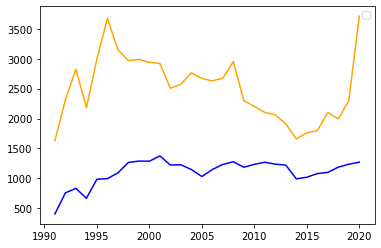

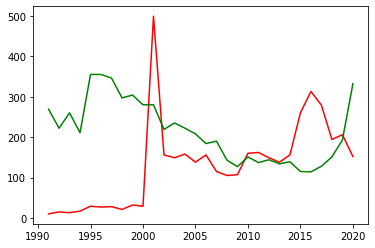

In [10]:
# muslim_bias.plot()
# black_bias.plot()
# asian_bias.plot()
# queer_bias.plot()


plt.plot(black_bias['TOTAL_INCIDENTS'], color='orange')
plt.plot(queer_bias['TOTAL_INCIDENTS'], color='blue')

plt.show()

plt.plot(muslim_bias['TOTAL_INCIDENTS'], color='red')


plt.plot(asian_bias['TOTAL_INCIDENTS'], color='green')

plt.show()